# Part B: Analysing CSV Data 
In this part,you will analyze crime data from South Australia.The dataset reflects reported incidents of crime(suburb-based crime statistics for crimes against the person and crimes against property.) that occurred in South Australia since 2010. Required Dataset (available in Moodle):-Crime_Statistics_SA_2010_present.csv<br> 
## Step 01: Import pyspark and initialize Spark <br>
You will use SparkContext from pyspark , which is the main entry point for SparkCore functionality. The SparkSession object provides methods used to create DataFrames from various input sources. A DataFrame is equivalent to a relational table in SparkSQL and can be created using various functions in SparkSession. Once created, it can be manipulated using the various domain-specific-language(DSL) functions defined in DataFrame, Column.<br> Write the code to create a SparkContext object, which tells Spark how to access a cluster. To create a Spark Context you first need to build a SparkConf object that contains information about your application. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. Write the code to create a SparkSession object that can be used to create the dataframe from the input data source (CSV file).

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .getOrCreate()


## Step 02: Create Dataframe<br>
Write the code to create a data frame and provide the data source as the CSV file. How many records are there in the dataframe?

In [2]:
df_crimeSA = spark.read.csv("Crime_Statistics_SA_2010_present.csv", header = True)
print('The dataframe has:',df_crimeSA.count(), 'records')

The dataframe has: 727408 records


## Step 03: Write to Database 
We will use MongoDB as our datasource. Therefore,as a data loading step, you are required to read the CSV file using spark session and insert all the records into MongoDB. Use the overwrite mode when you are inserting the data.

In [3]:
df_crimeSA.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

In [4]:
df_crimeSA.show(5)

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

## Step 04: Read from Database  
Create a Spark DataFrame to hold data from the MongoDB collection specified in the spark.mongodb.input.uri option which your SparkSession option is using. Display the schema of the dataframe. You will use this new dataframe to perform all the steps mentioned below.

In [5]:
df_crimeSA = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
df_crimeSA.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 05: Calculate the statistics of numeric and string columns 
Calculate the statistics of "OffenceCount" and "ReportedDate". Find the count, mean, standarddeviation, minimum and maximum for these attributes. Explain with reasoning whether the minimum and maximum reported date is correct.

In [6]:
# first remove NA rows
df_crimeSA_NA = df_crimeSA.na.drop(subset = ('Reported Date'))
print('with NAs',df_crimeSA.count())
print('without NAs',df_crimeSA_NA.count())

with NAs 727408
without NAs 727407


In [7]:
df_crimeSA_NA.select('Offence Count','Reported Date').describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378081|         null|
|    min|                 1|    1/01/2011|
|    max|                 9|    9/12/2018|
+-------+------------------+-------------+



<font color = "green"><b>
The minimum and maximum for reported date are incorrect due to the fact that its present type is actually a string, and not a date, as it should be. The logic for sorting strings is different, and the order of the characters is more important than the "whole number". For instance, 99 is considered a "higher" number than "101".  
</font><b>

## Step 06: Change the data type of a column

The Date ​column is in string format. You need to change it to date format using the user-defined functions (udf).

In [8]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType

to_date = udf(lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
df_crimeSA_date = df_crimeSA_NA.withColumn('Reported Date', to_date(col('Reported Date'))) 
df_crimeSA_date.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 07: Preliminary data analysis
Write the code to answer the following analytical queries.
- How many level 2 offences are there?


In [9]:
crimes_count = df_crimeSA_date.select('Offence Level 2 Description').distinct().collect()
print('There are', len(crimes_count), 'level 2 distinct offences')

There are 9 level 2 distinct offences


- Display the list of level 2 offences.

In [10]:
crimes_show = [row['Offence Level 2 Description'] for row in crimes_count]
print(crimes_show)

['ROBBERY AND RELATED OFFENCES', 'PROPERTY DAMAGE AND ENVIRONMENTAL', 'SEXUAL ASSAULT AND RELATED OFFENCES', 'HOMICIDE AND RELATED OFFENCES', 'ACTS INTENDED TO CAUSE INJURY', 'SERIOUS CRIMINAL TRESPASS', 'OTHER OFFENCES AGAINST THE PERSON', 'FRAUD DECEPTION AND RELATED OFFENCES', 'THEFT AND RELATED OFFENCES']


- What is the number of offences against the person?

In [11]:
# first change the type of "offence count"
from pyspark.sql.types import DoubleType, StringType 
df_crimeSA_integer = df_crimeSA_date.withColumn("Offence Count", df_crimeSA_date['Offence Count'].cast("integer"))

df_crimeSA_offence = df_crimeSA_integer.filter(df_crimeSA_integer
                                                  ['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')

df_crimeSA_offence.groupBy("Offence Level 1 Description").sum('Offence Count').show()

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|       OFFENCES AGAINST ...|            175644|
+---------------------------+------------------+



- How many serious criminal tresspasses with more than 1 offence count?


In [12]:
df_crimeSA_tressp = df_crimeSA_integer.filter(
    df_crimeSA_integer['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')
        
df_crimeSA_tressp_more = df_crimeSA_tressp.filter(
    df_crimeSA_tressp['Offence Count'] > 1)

print('There were',df_crimeSA_tressp_more.count(),'serious criminal tresspasses with more than 1 offence count')

There were 8579 serious criminal tresspasses with more than 1 offence count


- What percentage of crimes are offences against the property?

In [13]:
# Filter only offences against the property
df_crimeSA_prop = df_crimeSA_integer.filter(df_crimeSA_integer['Offence Level 1 Description'] == 'OFFENCES AGAINST PROPERTY')

# Count total of crime offences and only against the property
count_prop_offense = df_crimeSA_prop.groupBy("Offence Level 1 Description").sum().collect()[0]['sum(Offence Count)']
count_all_offense = df_crimeSA_integer.groupBy().sum().collect()[0]['sum(Offence Count)']

print('There proportion is ' + str(round(count_prop_offense/count_all_offense,4)*100) +'% of offences against the property')

There proportion is 79.39% of offences against the property


# Step 08: Exploratory data analysis
Next, write code to analyze the following analytical queries and visualise it using the standard python library- matplotlib. Please make sure you are aware of the different factors such as visualeffects , coordinatesystem, data type and scale and informative interpretation before data visualisation as well as you follow clarity, accuracy and efficiency.

- Find the number of crimes per year. Plot the graph and explain your understanding of the graph.


In [14]:
# making transformations
# import functions
# add a column with the year 

from pyspark.sql.functions import month, year, to_timestamp
df_crime_date = df_crimeSA_NA.select("Reported Date", "Offence Count").withColumn("Year", year(to_timestamp("Reported Date", 'dd/mm/yy')))

# change the column type of 'offence count' to double to perfomrm math calculations
df_crime_double = df_crime_date.withColumn("Offence Count", df_crime_date['Offence Count'].cast("double"))

# group by year the sum off crimes
df_crime_per_year = df_crime_double.groupby('Year').sum("Offence Count").dropna().sort('Year').collect()

In [15]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

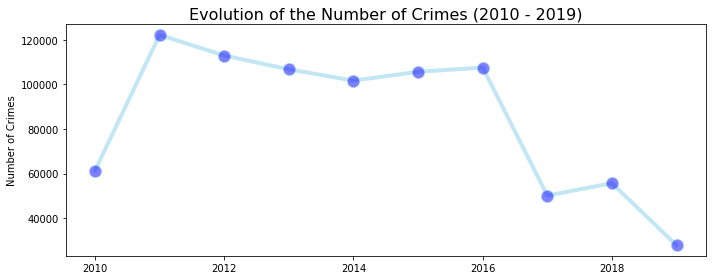

In [16]:
# transform the data into lists
y_axis = [row['Year'] for row in df_crime_per_year]
x_axis = [row['sum(Offence Count)'] for row in df_crime_per_year]

plt.figure(figsize=(10,4), tight_layout=True)
plt.plot(y_axis, x_axis, alpha=0.5, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.ylabel('Number of Crimes')
plt.title('Evolution of the Number of Crimes (2010 - 2019)', fontsize = 16)
plt.show()


<font color = "green"><b>
Considerations:
- There was a significant increase in crimes from 2010 to 2011.
- There was a slight downward trend until 2016.
- From 2016 to 2019, the number of crimes in South Australia decresead dramatically.
- The last year was the one with the smallest amount of crimes.
</font><b>


- Find the number of crimes per month. Plot the graph and explain your understanding of the graph.

In [17]:
# making transformations - subtracting and adding new columns
df_crimeSA_month = df_crimeSA_NA.select("Reported Date", "Offence Count").withColumn('Month', month(to_timestamp('Reported Date', 'd/MM/yyyy')))
df_crimeSA_int = df_crimeSA_month.withColumn('Offence Count', df_crimeSA_month['Offence Count'].cast('int'))
df_crimeSA_str = df_crimeSA_int.withColumn('Month', df_crimeSA_int['Month'].cast('string'))
df_crimeSA_month_int = df_crimeSA_str.withColumn('Month2', df_crimeSA_str['Month'].cast('double'))
df_crimeSA_per_month = df_crimeSA_month_int.groupby('Month','Month2').sum("Offence Count").sort('Month2')
df_crime_per_month = df_crimeSA_per_month.collect()

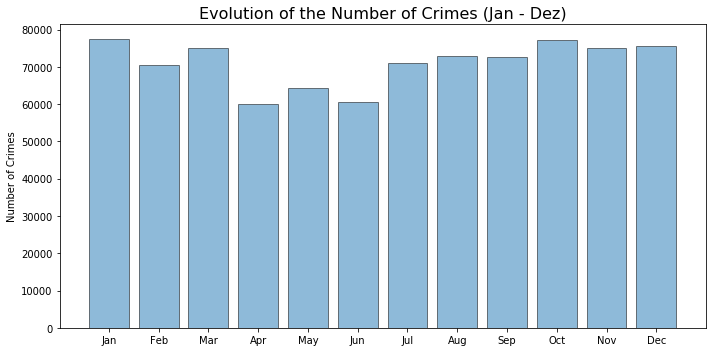

In [18]:
dict_month = {1.0:'Jan',2.0:'Feb',3.0:'Mar',4.0:'Apr',5.0:'May',6.0:'Jun',7.0:'Jul',8.0
              :'Aug',9.0:'Sep',10.0:'Oct',11.0:'Nov',12.0:'Dec'}

x_axis = [dict_month[row['Month2']] for row in df_crime_per_month]
y_axis = [row['sum(Offence Count)'] for row in df_crime_per_month]

plt.figure(figsize=(10,5), tight_layout=True)
plt.bar(x_axis, y_axis, align='center', alpha=0.5, tick_label = x_axis, edgecolor='black')
plt.ylabel('Number of Crimes')
plt.title('Evolution of the Number of Crimes (Jan - Dez)', fontsize = 16)

plt.show()

<font color = "green"><b>
Considerations:
- There is a clear trend: During the midle of the year less crimes occur. 
    - This must be a consequence of cold weather. People are less present in the street.
- However, the variance of crimes over months is not very high and no month stands out from others.
</font><b>

- Where do most crimes take place? Find the top 20 suburbs (which would also display post code for e.g.Caulfield-3162)? Plot the graph and explain your under standing of the graph.

In [19]:
df_crime_per_suburb = df_crimeSA_integer.groupby(['Postcode - Incident','Suburb - Incident']).sum('Offence Count')
df_crime_per_suburb = df_crime_per_suburb.sort('sum(Offence Count)', ascending = False)
df_crime_per_suburb_chart = df_crime_per_suburb.limit(20).collect()

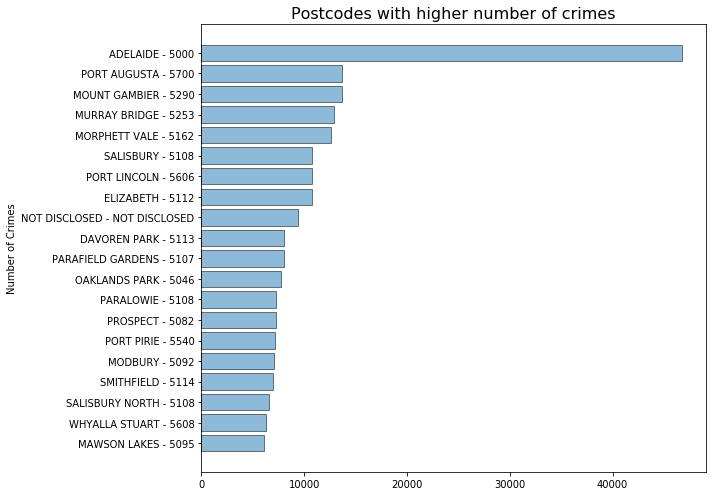

In [20]:
x_axis1 = [row['Suburb - Incident'] for row in df_crime_per_suburb_chart]
x_axis2 = [row['Postcode - Incident'] for row in df_crime_per_suburb_chart]
x_axis = list(map(" - ".join, zip(x_axis1,x_axis2)))
x_axis

y_axis = [row['sum(Offence Count)'] for row in df_crime_per_suburb_chart]

plt.figure(figsize=(10,7), tight_layout=True)
plt.barh(x_axis, y_axis, align='center', alpha=0.5, tick_label = x_axis, edgecolor='black')
plt.gca().invert_yaxis()
plt.ylabel('Number of Crimes')
plt.title('Postcodes with higher number of crimes', fontsize = 16)

plt.show()

<font color = "green"><b>
- The postcode of Adelaide stands out in this chart, as it presents at least four times more crimes than  any other postcode. 
- If we exclude Adelaide from the chart, we will see a distribution with less variance and more uniform.
- There is a postcode called "Not Disclosed" that was preserved, but apperantly does not represents a specific postcode.  
</font><b>

- Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

In [21]:
funcWeekDay =  udf(lambda x: datetime.strptime(x, '%d/%m/%Y').strftime('%w'))
df_crimeSA_week = df_crimeSA.withColumn('Weekday', funcWeekDay(col('Reported Date'))) 
df_crimeSA_week.select('Reported Date', 'Weekday').show(5)

+-------------+-------+
|Reported Date|Weekday|
+-------------+-------+
|    1/07/2010|      4|
|    1/07/2010|      4|
|    1/07/2010|      4|
|    1/07/2010|      4|
|    1/07/2010|      4|
+-------------+-------+
only showing top 5 rows



In [22]:
df_crimeSA_week_offence = df_crimeSA_week.filter(
    df_crimeSA_week['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')

df_crime_week_offence_month = df_crimeSA_week_offence.select("Reported Date", "Offence Count",'Weekday').withColumn('Month', month(to_timestamp('Reported Date', 'd/MM/yyyy')))

df_crime_week_offence_month_double = df_crime_week_offence_month.withColumn('Offence Count', df_crime_week_offence_month['Offence Count'].cast('double'))
df_crime_week_offence_month_double_string = df_crime_week_offence_month_double.withColumn('Month', df_crime_week_offence_month_double['Month'].cast('string'))
df_crime_week_offence_month_double = df_crime_week_offence_month_double_string.withColumn('Month2', df_crime_week_offence_month_double_string['Month'].cast('double'))
df_crime_week_offence_month_resume = df_crime_week_offence_month_double.groupby(['Month','Month2','Weekday']).sum('Offence Count').sort('Weekday', 'Month2')
df_crimeSA_resume = df_crime_week_offence_month_resume.collect()

In [23]:
df_crimeSA_resume[0:5]

[Row(Month='1', Month2=1.0, Weekday='0', sum(Offence Count)=1309.0),
 Row(Month='2', Month2=2.0, Weekday='0', sum(Offence Count)=1143.0),
 Row(Month='3', Month2=3.0, Weekday='0', sum(Offence Count)=1310.0),
 Row(Month='4', Month2=4.0, Weekday='0', sum(Offence Count)=1097.0),
 Row(Month='5', Month2=5.0, Weekday='0', sum(Offence Count)=1138.0)]

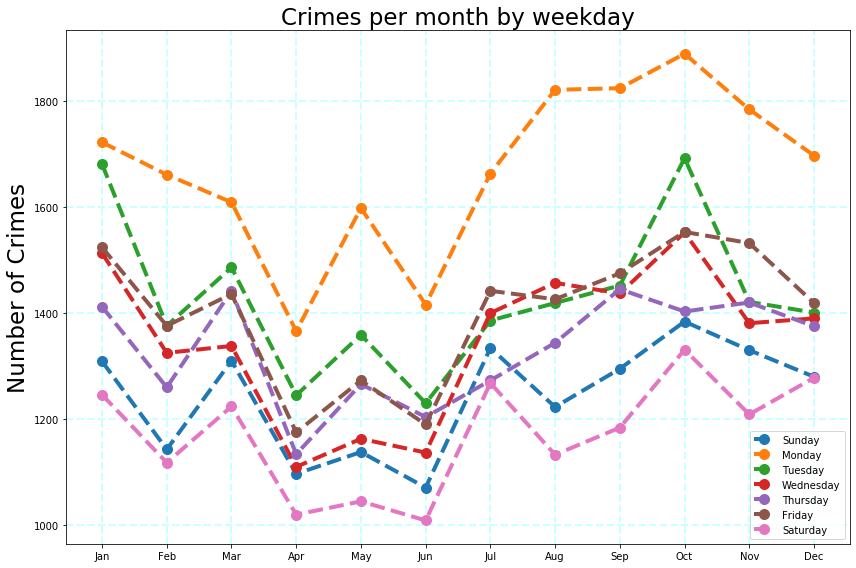

In [24]:
# libraries
import numpy as np
import matplotlib.pyplot as plt 
 
# Values of each group
sunday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '0']
monday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '1']
tuesday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '2']
wednesday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '3']
thursday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '4']
friday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '5']
saturday = [row['sum(Offence Count)'] for row in df_crimeSA_resume if row['Weekday'] == '6']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

   
plt.figure(figsize=(12,8), tight_layout=True)
 
# multiple line plot
plt.plot( months, sunday, marker='o', label = 'Sunday', linestyle='dashed', markersize=10, linewidth=4)
plt.plot( months, monday, marker='o', label = 'Monday',linestyle='dashed', markersize=10, linewidth=4)
plt.plot( months, tuesday, marker='o', label = 'Tuesday', linestyle='dashed', markersize=10, linewidth=4)
plt.plot( months, wednesday, marker='o', label = 'Wednesday', linestyle='dashed', markersize=10, linewidth=4)
plt.plot( months, thursday, marker='o', label = 'Thursday',  linestyle='dashed',markersize=10, linewidth=4)
plt.plot( months, friday, marker='o', label = 'Friday', linestyle='dashed', markersize=10, linewidth=4)
plt.plot( months, saturday, marker='o', label = 'Saturday', linestyle='dashed',markersize=10, linewidth=4)

plt.grid(color='aqua', linestyle='--', linewidth=2, alpha = 0.2)
plt.legend()
plt.title('Crimes per month by weekday', fontsize = 23)
plt.ylabel("Number of Crimes",fontsize = 23)
 
# Show graphic
plt.show()

<font color = "green"><b>
The plot indicates the following:
- Most serious criminal trespasses happen during weekdays. Satuday and Sunday are the most uncommon days for such crimes. The first day of the week, monday, is when most crimes occour.
- Serious criminal trespasses are more likely to occour in the end or the beggining of the year, they are less frequent during winter, for instance.
- The most unlikely months for these crimes are April and June. October is the most frequent month for serious criminal trespasses.
</font><b>